# Ising Model -- Logistic Regression
Here, I investigate how well a logistic regression model is able to classify simulation results of the 2-D Ising model into "low" and "high" temperature phases.

For for information about the Ising model, see the README or the [wiki page][example].

  [example]: https://en.wikipedia.org/wiki/Ising_model

I first demonstrate image classification using logisitic regression on the MNIST dataset. Then, I apply logistic regression to my Ising model simulation data.

In [131]:
%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

## Logistic Regression on MNIST

### Load MNIST Data

In [133]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images /255.0

### Build logistic regression model
Here I construct a neural net without hidden layers

In [138]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [139]:
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [140]:
model2.fit(train_images,train_labels, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 4s 68us/sample - loss: 0.4752 - acc: 0.8759
Epoch 2/3
60000/60000 [==============================] - 4s 64us/sample - loss: 0.3042 - acc: 0.9148
Epoch 3/3
60000/60000 [==============================] - 4s 64us/sample - loss: 0.2832 - acc: 0.9203


In [141]:
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [142]:
model2.fit(train_images,train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 4s 68us/sample - loss: 0.2703 - acc: 0.9248
Epoch 2/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.2659 - acc: 0.9260
Epoch 3/5
60000/60000 [==============================] - 4s 65us/sample - loss: 0.2625 - acc: 0.9269
Epoch 4/5
60000/60000 [==============================] - 4s 65us/sample - loss: 0.2599 - acc: 0.9279
Epoch 5/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.2575 - acc: 0.9286


In [143]:
test_loss, test_acc = model2.evaluate(test_images, test_labels,)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

10000/10000 [==============================] - 1s 63us/sample - loss: 0.2630 - acc: 0.9273
Test accuracy: 0.9273
Test loss: 0.2629511542677879


Just with this simple logistic regression, we achieve about 93% accuracy on our test set for MNIST

Now we try on the Ising model data

## Logistic Regression on Ising Model

### Load Data

In [144]:
train_path = '../../data/Ising/train20v2/'
valid_path = '../../data/Ising/valid20v2/'
test_path = '../../data/Ising/testTri20v2/'

Set up some helper functions to load and label the data.

The file name for each simulation is in the form ```phase_Temp_index_.npy``` where ```phase``` is either "high" or "low" and is the label I am training with. I also keep track of the temperature of each of the simulations, which will allow me to determine the critical phase transition temperature. Finally, ```index``` simply provides a unique file name to each configuration.

In [145]:
def one_hot_label(img):
    # img is the file name of a configuration
    label,T,_,_ = img.split('_')
    if label == 'low':
        ohl = np.array([1,0])
    elif label == 'high':
        ohl = np.array([0,1])
    return ohl,T
def data_with_label(data_path,*args):
    data = []
    if args: # The args are a list if directories in the data path that separate the classes/categories
        for category in args:
            for i in tqdm(os.listdir(data_path + category)):
                path = os.path.join(data_path, category,i)
                img = np.load(path)
                data.append([img.astype(dtype='float32'), one_hot_label(i)])
        shuffle(data)
        return data

Load in the train and validation sets.

Each element of the sets consists of a tuple of the form: (numpy array, \[one hot label, temperature\])

In [146]:
train_set=data_with_label(train_path,'low','high')
valid_set=data_with_label(valid_path,'low','high')

100%|██████████| 3200/3200 [00:00<00:00, 3775.57it/s]


Separate the loaded data into arrays containing the image data, label data, and temperature data.

In [147]:
tr_img_data = np.array([i[0] for i in train_set])
tr_lbl_data = np.array([i[1][0] for i in train_set])
tr_Temp_data = np.array([i[1][1] for i in train_set])
val_img_data = np.array([i[0] for i in valid_set])
val_lbl_data = np.array([i[1][0] for i in valid_set])
val_Temp_data = np.array([float(i[1][1]) for i in valid_set])

Take a look at a few samples.

The low temperature configurations tend to be predominately aligned in either the "up" (yellow) or "down" (purple) directions. This is expected since aligned spins is a lower energy state. For the high temperature configurations, clusters of aligned spins of various sizes form.  

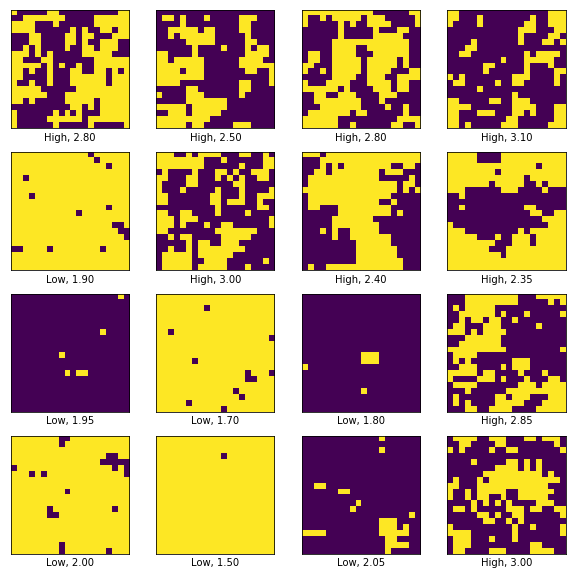

In [148]:
plt.figure(figsize=(10,10))
for i in range(16):
    #idx=bad_predictions[i]
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tr_img_data[i])
    if tr_lbl_data[i][0] == 1:
        label = "Low"
    elif tr_lbl_data[i][1] == 1:
        label = "High"
    plt.xlabel(f'{label}, {tr_Temp_data[i]}')

### Build logistic regression model

There are only 2 classes: "Low temperature" and "High temperature"

In [149]:
model3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [154]:
model3.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [156]:
model3.fit(x=tr_img_data,y=tr_lbl_data, epochs=15)


Epoch 1/15
30000/30000 [==============================] - 2s 73us/sample - loss: 0.7046 - acc: 0.5156
Epoch 2/15
30000/30000 [==============================] - 2s 72us/sample - loss: 0.7039 - acc: 0.5171
Epoch 3/15
30000/30000 [==============================] - 2s 73us/sample - loss: 0.7045 - acc: 0.5201
Epoch 4/15
30000/30000 [==============================] - 2s 73us/sample - loss: 0.7045 - acc: 0.5155
Epoch 5/15
30000/30000 [==============================] - 2s 74us/sample - loss: 0.7051 - acc: 0.5258
Epoch 6/15
30000/30000 [==============================] - 2s 73us/sample - loss: 0.7076 - acc: 0.5212
Epoch 7/15
30000/30000 [==============================] - 2s 73us/sample - loss: 0.7053 - acc: 0.5156
Epoch 8/15
30000/30000 [==============================] - 2s 72us/sample - loss: 0.7031 - acc: 0.5200
Epoch 9/15
30000/30000 [==============================] - 2s 73us/sample - loss: 0.7056 - acc: 0.5221
Epoch 10/15
30000/30000 [==============================] - 2s 72us/sample - loss: 

#### Interestingly, we can not do much better than 50% accuracy on our training data!

We can try adding just a single small hidden layer

## Single hidden layer NN

In [157]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(20, 20)),
    keras.layers.Dense(10, activation=tf.nn.sigmoid),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [158]:
model1.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [159]:
model1.fit(x=tr_img_data,y=tr_lbl_data, epochs=15)

Epoch 1/15
30000/30000 [==============================] - 3s 91us/sample - loss: 0.6706 - acc: 0.6707
Epoch 2/15
30000/30000 [==============================] - 2s 78us/sample - loss: 0.4312 - acc: 0.9131
Epoch 3/15
30000/30000 [==============================] - 2s 79us/sample - loss: 0.2667 - acc: 0.9236
Epoch 4/15
30000/30000 [==============================] - 2s 78us/sample - loss: 0.2047 - acc: 0.9319
Epoch 5/15
30000/30000 [==============================] - 2s 79us/sample - loss: 0.1774 - acc: 0.9370
Epoch 6/15
30000/30000 [==============================] - 2s 79us/sample - loss: 0.1648 - acc: 0.9397
Epoch 7/15
30000/30000 [==============================] - 2s 79us/sample - loss: 0.1547 - acc: 0.9430
Epoch 8/15
30000/30000 [==============================] - 2s 79us/sample - loss: 0.1477 - acc: 0.9445
Epoch 9/15
30000/30000 [==============================] - 2s 79us/sample - loss: 0.1419 - acc: 0.9465
Epoch 10/15
30000/30000 [==============================] - 2s 78us/sample - loss: 

Evaluate the model performance on the validation set.

In [160]:
val_loss, val_acc = model1.evaluate(val_img_data, val_lbl_data,)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

6000/6000 [==============================] - 1s 92us/sample - loss: 0.1696 - acc: 0.9360
Validation accuracy: 0.936
Validation loss: 0.16958255623281002


#### By only adding a single hidden layer with 10 nodes we achieve 93%+ accuracy on the validation set! Much imporoved over the logistic regression!